# Compute wham bias from OPES runs

## import required libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.pyplot import cm

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['font.family'] = 'Sans'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.linewidth'] = 2

%matplotlib inline

## Run script in notebook or in terminal to get bias values from other runs corresponding to colvars from run i

In [ ]:
%%bash
bash utils/get_bias.sh aligned.readbias.dat

## Read colvars and bias from OPES runs where projection and extension cvs along and from axis between A1-A2 and A4-A5 were biased

In [2]:
workdir = "" # directory where colvars and biases are 
figure_dir = '../outfigs'
out_dir = '../outputs'
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(out_dir, exist_ok=True)
workdir

''

In [3]:
cv_bias_data = {}
walls_data = {}

for i in np.linspace(0.0,0.0,1):
    if round(i,3) == -0.0:
        key = "0.0"
    else:
        key = str(round(i,3))
    cv_bias_data[key]=[]
    walls_data[key]=[]

file_template = "_FORCE/DIR/DIR_fes_pullVt_rerun_WIN.colvar_bias.out"

for key in cv_bias_data:
    file_name = file_template.replace('FORCE', key)
     # 20 runs labeled 26 to 45
    for run in range(26,46):
        run_name = file_name.replace('DIR',str(run))
        final_name=run_name.replace('WIN', str(26))
        dist = np.genfromtxt(workdir+final_name, comments='#', dtype=float, usecols = (0,1,2,3,4), skip_header=1501) #skip transient
        biases = dist[::25]
        for win in range(27,46):
            # print(run,win,key)
            final_name=run_name.replace('WIN', str(win))
            bias_win = np.genfromtxt(workdir+final_name, comments='#', dtype=float, usecols = (4), skip_header=1501)
            biases = np.hstack((biases,np.reshape(bias_win[::25],(-1,1))))
            
        cv_bias_data[key].append(biases)
        

## Read wall bias

In [4]:
file_template =  "_FORCE/DIR/DIR_fes_pullVt.walls.out"
for key in cv_bias_data:
    file_name = file_template.replace('FORCE', key)
    temp = []
    for run in range(26,46):
        final_name = file_name.replace('DIR',str(run))
        dist = np.genfromtxt(workdir+final_name, comments='#', dtype=float, skip_header=1501)
        walls = dist[:,1:][::25]
        total_walls = np.sum(walls,axis=1)
        outcolumn = np.vstack((dist[:,0][::25], total_walls))
        temp.append(outcolumn.transpose())
    walls_data[key] = temp

## Concatenate colvars and biases

In [5]:
kbT = 0.596161
barrier = 25 # BARRIER parameter used in OPES runs

concat_cvs_bias = {}
concat_walls = {}
concat_walls_time ={}

for key in cv_bias_data:
    biases = cv_bias_data[key]
    concatenated_opes_bias = biases[0]
    walls = walls_data[key]
    concatenated_wall_bias = walls[0][:,1][::]
    cat_wall_time = walls[0][::]

    for i in range(1, len(biases)):
        bias = biases[i]
        wall_bias = walls[i]
        concatenated_opes_bias = np.concatenate((concatenated_opes_bias,bias), axis=0)
        concatenated_wall_bias = np.concatenate((concatenated_wall_bias, wall_bias[:,1][::]), axis=0)
        cat_wall_time = np.concatenate((cat_wall_time, wall_bias[::]), axis=0)
        
    concat_cvs_bias[key] = concatenated_opes_bias
    concat_walls[key] = concatenated_wall_bias
    concat_walls_time[key] = cat_wall_time


## Run wham to obtain optimized bias

In [6]:
from utils.wham import wham
wham_weights = {}
for key in concat_cvs_bias:
    concatenated_bias=concat_cvs_bias[key][:,4:]
    print(f"force: {key}")
    w=wham(concatenated_bias,T=kbT, verbose=False)
    wham_weights[key] = w['logW']


force: 0.0


## Write to files for reweighting and fes computation with plumed

In [8]:
for key in concat_cvs_bias:
    cvs = concat_cvs_bias[key][:,:4]
    walls_t = concat_walls_time[key]
    wham_bias = wham_weights[key]*kbT
    filename = f'{out_dir}/COLVAR_cat_{key}.dat'
    head=" FIELDS time proj ext cmap"
    np.savetxt(filename, cvs, delimiter=' ', newline='\n', header=head, comments='#!', fmt='%.6e')
    filename = f'{out_dir}/WALL_cat_{key}.dat'
    head=" FIELDS time totalwall.bias"
    np.savetxt(filename, walls_t, delimiter=' ', newline='\n', header=head, comments='#!', fmt='%.6e')
    wham_bias_t = np.hstack((cvs[:,0].reshape(-1,1),wham_bias.reshape(-1,1)))
    filename = f'{out_dir}/BIAS_cat_{key}.dat'
    head=" FIELDS time wham.bias"
    np.savetxt(filename, wham_bias_t, delimiter=' ', newline='\n', header=head, comments='#!', fmt='%.6e')
     

## Run in notebook or terminal to obtain FES ouputs

In [ ]:
%%bash
bash utils/reweight_cat.sh reweight.plumed.dat

## Read FES 

In [7]:
all_fes_ext_proj = {}
all_fes_proj_cmap = {}
all_fes_ext_cmap = {}

all_fes_ext = {}
all_fes_proj = {}
all_fes_cmap = {}

for i in np.linspace(0.0,0.0,1):
    if round(i,3) == -0.0:
        key = "0.0"
    else:
        key = str(round(i,3))
    all_fes_ext_proj[key]=[]
    all_fes_ext[key]=[]
    all_fes_proj[key]=[]
    all_fes_cmap[key] = []
    all_fes_proj_cmap[key] = []
    all_fes_ext_cmap[key] = []


file_template = "../outputs/FFORCE_fes_projext_rw.dat"
for k in all_fes_ext_proj:
    final_name = file_template.replace('FORCE', k)
    dist = np.genfromtxt(final_name, comments='#',dtype=float)
    all_fes_ext_proj[k].append(dist)

    
file_template = "../outputs/FFORCE_fes_projcmap_rw.dat"
for k in all_fes_proj_cmap:
    final_name = file_template.replace('FORCE', k)
    dist = np.genfromtxt(final_name, comments='#',dtype=float)
    all_fes_proj_cmap[k].append(dist)

file_template = "../outputs/FFORCE_fes_extcmap_rw.dat"
for k in all_fes_ext_cmap:
    final_name = file_template.replace('FORCE', k)
    dist = np.genfromtxt(final_name, comments='#',dtype=float)
    all_fes_ext_cmap[k].append(dist)
        
file_template = "../outputs/FFORCE_fes_proj_rw.dat"
for k in all_fes_proj:
    final_name = file_template.replace('FORCE', k)
    dist = np.genfromtxt(final_name, comments='#',dtype=float)
    all_fes_proj[k].append(dist)
        
file_template = "../outputs/FFORCE_fes_ext_rw.dat"
for k in all_fes_ext :
    final_name = file_template.replace('FORCE', k)
    dist = np.genfromtxt(final_name, comments='#',dtype=float)
    all_fes_ext[k].append(dist)
      
file_template = "../outputs/FFORCE_fes_cmap_rw.dat"
for k in all_fes_cmap:
    final_name = file_template.replace('FORCE', k)
    dist = np.genfromtxt(final_name, comments='#',dtype=float)
    all_fes_cmap[k].append(dist)

## import string function to find MEP and then plot 2D FES with path

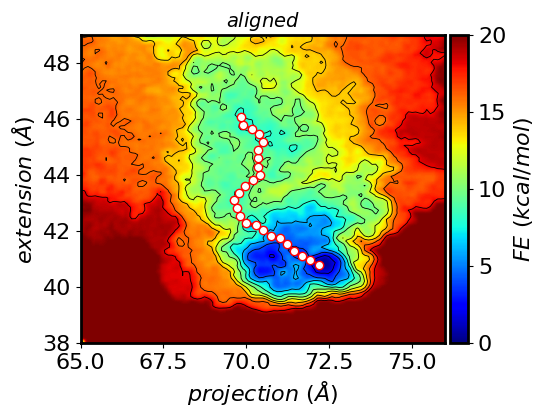

In [8]:
from utils.stringbase import *

maxFE=20
force_barriers_str = {}

file_template = "../outputs/FFORCE_fes_projext_rw.dat"
for key in all_fes_ext_proj:
    runs=all_fes_ext_proj[key]
    final_name = file_template.replace('FORCE', key)
    for i,run in enumerate(runs):
        fig,ax = plt.subplots(figsize=(5, 4))
        x = run[:,0]
        y = run[:,1]
        z = run[:,2]
        index=np.where((z>=maxFE))[0]
        z[index]=maxFE
        X = np.linspace(np.amin(x),np.amax(x), 101)
        Y = np.linspace(np.amin(y), np.amax(y), 101)
        XZ = z.reshape(101,101)
        #fes_twocv.append(XZ)
        ax.contour(X, Y, XZ, 10, colors='black', linewidths=0.6)
        im=ax.imshow(XZ,aspect='auto',origin='lower', cmap='jet', interpolation="gaussian", extent=(x.min(), x.max(), y.min(), y.max()))
        ax.set_title(r"$aligned$", size=14)
        ax.set_xlabel(r'$projection\ (\AA)$', size=16)
        ax.set_ylabel(r'$extension\ (\AA)$', size=16)
        # ax.set_xticks([i for i in range(40,91,5)])
        divider = make_axes_locatable(ax)
        cax2 = divider.append_axes("right", size="5%", pad=0.05)
        cbar=fig.colorbar(im, ax=ax, cax=cax2)
        cbar.ax.tick_params(labelsize=16)
        cbar.set_label(r"$FE\ (kcal/mol)$")
        
        landscape = Landscape.from_plumed(final_name,maxFE)
        
        if float(key)< 0:
            x_string=np.linspace(71,71,20) #Initial guess for the position of nodes of the string
            y_string=np.linspace(40.,46,20)

        elif float(key)==0:
            x_string=np.linspace(72.5,69.5,20) #Initial guess for the position of nodes of the string
            y_string=np.linspace(40.5,46.0,20)
    
        else:
            x_string=np.linspace(72.5,70,20) #Initial guess for the position of nodes of the string
            y_string=np.linspace(40.5,46,20)
        
        string = String(x_string,y_string)
        string.reparameterize(len(x_string))
        np.random.seed(8)

        drift_factor = 0.001
        sigma = 0.01 #for random walk
        N = 25
        t = 0


        string_history = [(string.xdata.copy(),string.ydata.copy())]

        for t in range(4000):
            string.random_walk(sigma,sigma)
            string.drift(landscape,drift_factor)
            string.untangle()
            string.reparameterize(N)
            string_history.append((string.xdata.copy(),string.ydata.copy()))

        
        idx_point = np.arange(0,len(string.get_pmf(landscape)),1)
        data_min = [idx_point,string.get_pmf(landscape)-min(string.get_pmf(landscape))]
        force_barriers_str[key]=data_min
    
        ax.plot(string.xdata,string.ydata, 'o-', markerfacecolor='w', c='r')
        fig.savefig(F"{figure_dir}/fes_extproj_rw_{key}_plumed_wham_str.png", bbox_inches='tight')
        plt.show()       